# Project II: Economic Growth 

### By Astrid Fugleholm, Jacob Strabo, and Jørgen Høst

In [1]:
# Importing packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import Lasso
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

# Toolbox
import HDmodels as hd

## 1. Read Data

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary

print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


### 1.1 Identify dummy variables

In [3]:
category_features = []
threshold = 2
for each in dat.columns:
    if dat[each].nunique() == threshold:
        category_features.append(each)

for each in category_features:
    dat[each] = dat[each].astype('category')

dummies = dat.select_dtypes('category')

## 2. Descriptive Plots

## 3. Collection of Variables

In [4]:
# Variables regarding institutions
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 

# Variables regarding geography
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]

# Variables regarding genetic diversity
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']

# Variables regarding historical events
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']

# Variables regarding religion
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']

# Variables regarding the level of danger in countries
vv_danger = ['yellow', 'malfal',  'uvdamage']

# Variables regarding natural resources in countries
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']

# Variables regarding educational attainment level of populations in countries 
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

# A collection of all available variables grouped based on category
vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

### 3.1 Initial Selection of Controls

Method: On the basis of `materialize.ipynb`, select variables that has *at least* 90%-95% non-missing observations of GDP growth.

In [5]:
share_of_non_mis_obs = 0.95

temp = dat[dat.gdp_growth.notnull()].notnull().mean()>share_of_non_mis_obs
temp2 = temp.to_dict()

# Delete vars that has less than 90% non-missing obs for GDP growth
# NB! Not necessarily optimising the number of observations (different pairs could yield the higher number of observations)
for key, val in temp2.copy().items():
    if val == False:
        del temp2[key]

# Save the 'vars' for later
vars_to_keep = list(temp2.keys())
vs_las = vv_all['institutions'] + vv_all['geography'] + vv_all['historical'] + vv_all['religion'] + vv_all['resources'] + vv_all['educ']

vs_las_final = [item for item in vs_las if item in vars_to_keep]

In [6]:
## Based on our '95%' rule, select variables ##

# Possible controls (z_i)
z_las_final = ['pop_growth', 'investment_rate'] + vs_las_final

# Initial gdp (beta)
b_las_final = ['lgdp_initial']

# avoiding missings
all_vars = ['gdp_growth'] + z_las_final + b_las_final
I = dat[all_vars].notnull().all(1)

# extract data (We split it up, this makes sense later)
# Possible controls (z_i)
Z_las_95_rule = dat.loc[I, z_las_final].values  

# Initial GDP (beta)
B_las_95_rule = dat.loc[I, b_las_final].values 

# Stack both X=np.hstack(())
X_las_95_rule = np.column_stack((B_las_95_rule,Z_las_95_rule))

y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%
X_las_95_rule.shape
# Add polynomial features and interaction terms
poly = PolynomialFeatures(2)
X_poly_95 = poly.fit_transform(X_las_95_rule)

# Standardize our data (including intial GDP)
X_tilde_poly_95 = hd.standardize(X_poly_95)

X_tilde_poly_95.shape

(92, 406)

We will then proceed by treating this new list of variables in a high-dimensional paradigm. 

## 4. Lasso

As we would like to include as many controls as possible in our regression, and we have a data set with observations on 102 countries and 85 variables, OLS will not be feasible. Further, we believe that our ability to select the most important variables for predicting annual growth rate in GDP per capita are not as good as estimators like Lasso, we rely on these smarter methods for our predictions. 

### 4.1: LASSO (HD, 95% rule, polynomial features added)

$$
\left(\widehat{\beta}_0(\lambda), \widehat{\beta}(\lambda)\right) \in \underset{\left(b_0, b\right) \in \mathbf{R}^{1+p}}{\operatorname{argmin}}\left\{\frac{1}{2 n} \sum_{i=1}^n\left(Y_i-b_0-X_i^{\prime} b\right)^2+\lambda \sum_{j=1}^p\left|b_j\right|\right\}
$$

We construct a Lasso path which visualizes which control variables are being shut down for given penalty levels. This will reveal which variables are most reasonable to include in our estimation in the sense that they are important for prediction annual growth in GDP per capita.  

In [7]:
# Creating a grid of candidate penalty levels
penalty_grid = np.geomspace(1e-8,1e-2)

# Empty list for coefs
coefs=[]

# Estimating the model using Lasso for a given penalty level over a lopp using sklearn.linear_model.Lasso
for l in penalty_grid:
    clf = Lasso(alpha=l, max_iter=100000, tol=1e-2, fit_intercept=False)
    clf.fit(X_tilde_poly_95,y)
    coefs.append(clf.coef_)

c:\Users\JBH\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.401e+01, tolerance: 3.991e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\JBH\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.376e+01, tolerance: 3.991e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\JBH\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.362e+01, tolerance: 3.9

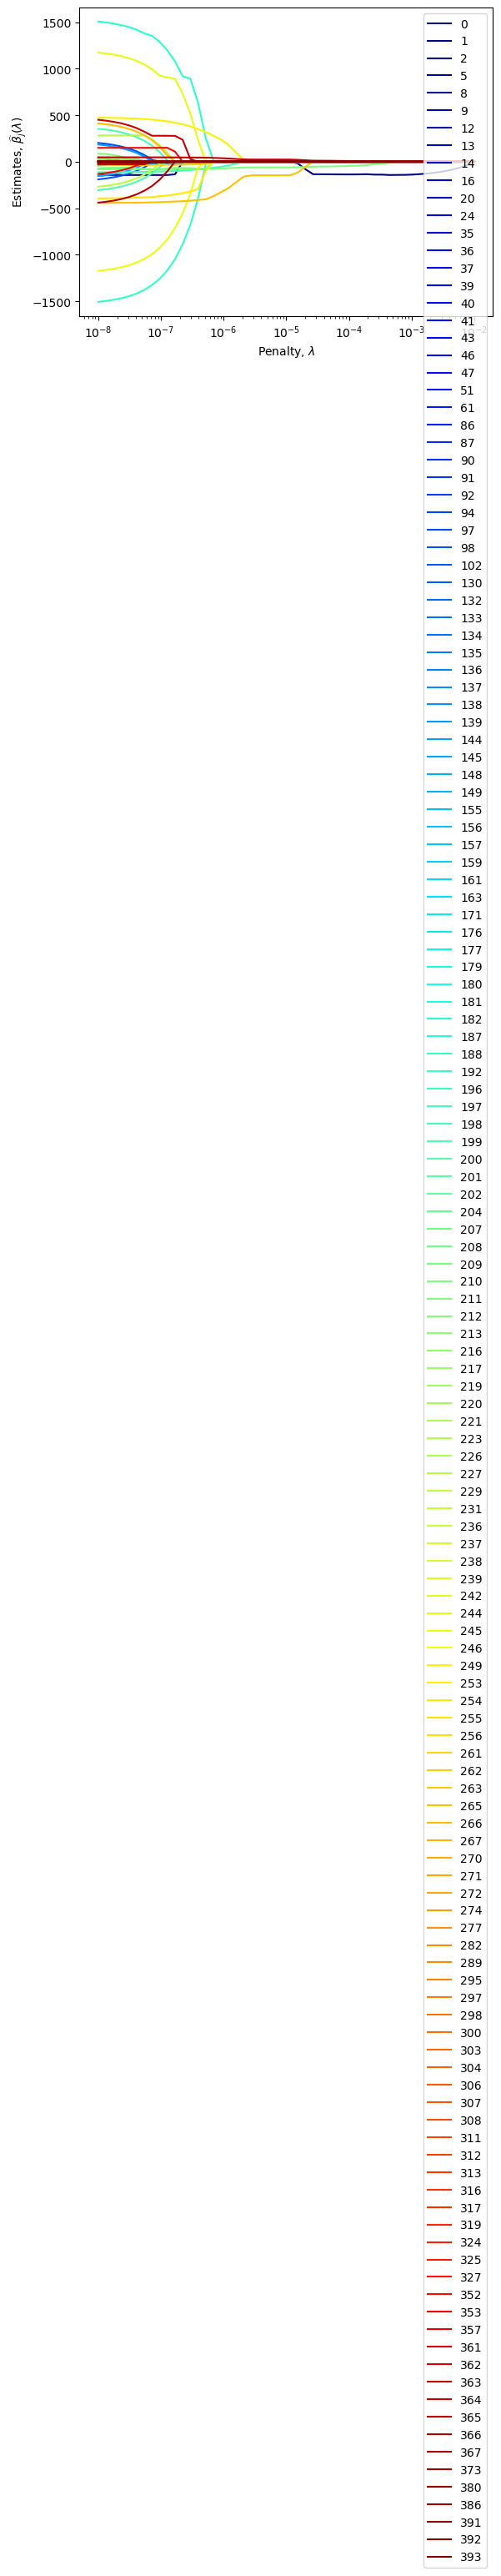

In [8]:
df = pd.DataFrame(dict(zip(penalty_grid,coefs)))
df_no_zeros = df.loc[(df!=0).any(axis=1)].T.plot(logx=True, colormap='jet')
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.savefig(f'_draft_fig_lasso_poly_{share_of_non_mis_obs}_rule.pdf', bbox_inches = "tight")

### 4.2. Lasso with Cross Validation 

Would avoid CV, as we have such a small dataset...(?)

### 4.3. Lasso with BRT

\begin{align}
    \hat{\lambda}^{B R T}   &=\frac{2 c \sigma}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right) \sqrt{\max _{1 \leq j \leq p} \frac{1}{N} \sum_{i=1}^N \mathbf{X}_i^2} \Leftrightarrow \\

    \hat{\lambda}^{B R T}   &=\frac{2 c \sigma}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right)
\end{align}

The last term = 1 only happens, if standardize $\mathbf{X}_i$.

In [9]:
lambda_BRT = hd.penalty_BRT(X_tilde_poly_95, y)

clf_BRT = Lasso(alpha=lambda_BRT/2, fit_intercept=False)

clf_BRT.fit(X_tilde_poly_95, y)
coeff_BRT =clf_BRT.coef_

print("lambda_BRT =",(lambda_BRT/2).round(2))

lambda_BRT = 0.64


In [10]:
np.count_nonzero(coeff_BRT)

1

### 4.4 Lasso with BCCH

$$
\hat{\lambda}^{\text {pilot }}=\frac{2 c}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right) \sqrt{\max _{1 \leq j \leq p} \frac{1}{N} \sum_{i=1}^N\left(Y_i-\bar{Y}\right)^2\textcolor{red}{'} \mathbf{X}_i^2}
$$

Then,

$$
\hat{\lambda}^{B C C H}=\frac{2 c}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right) \sqrt{\max _{1 \leq j \leq p} \frac{1}{N} \sum_{i=1}^N \hat{\epsilon}_i^{\textcolor{red}{2}} \mathbf{X}_i^2}
$$

In [11]:
lambda_BCCH = hd.penalty_BCCH(X_tilde_poly_95, y)

print('lambda_BCCH=', lambda_BCCH/2)

lambda_BCCH= 48.01448120863915


## 5. Post-Lasso

Suppose a model:

$$
Y=\alpha_0 D+Z^{\prime} \gamma_0+\varepsilon, \quad \mathrm{E}[\varepsilon \mid D, Z]=0
$$

### 5.1 Partialling Out Lasso

$$
\hat{\alpha}=\frac{\sum_{i=1}^N\left(Y_i-\mathbf{Z}_{i, J, Y} \hat{\boldsymbol{\phi}}\right)\left(D_i-\mathbf{Z}_{i, J, D} \hat{\boldsymbol{\delta}}\right)}{\sum_{i=1}^N\left(D_i-\mathbf{Z}_{i, J, D} \hat{\boldsymbol{\delta}}\right)^2}=\frac{\sum_{i=1}^N \hat{v}_i \hat{w}_i}{\sum_{i=1}^N \hat{w}_i^2}
$$

1) Lasso `gdp_growth` on controls $z_i$ (based on 95% rule). Save residuals.
2) Lasso `initial_gdp` on controls $z_i$. Save residuals
3) Calculate $\hat{\alpha}$
4) Calculate (implied) variance 
    - LASSO `gdp_growth` on X=((beta,z_i)). Save residuals
5) Calculate confidence interval

In [17]:
#BRT penalty

POL_BRT, penalty_BRT_yz, penalty_BRT_bz, CI_POL_BRT, se_POL_BRT, N, p = hd.part_out_LASSO(X_tilde=X_tilde_poly_95, Z=Z_las_95_rule, d=B_las_95_rule, y=y, penalty='BRT')

# BCCH penalty
POL_BCCH, penalty_BCCH_yz, penalty_BCCH_bz, CI_POL_BCCH, se_POL_BCCH, N, p = hd.part_out_LASSO(X_tilde=X_tilde_poly_95, Z=Z_las_95_rule, d=B_las_95_rule, y=y, penalty='BCCH')

In [19]:
# Q: Include count of non-zero coefficients?

# Collect results in table
results = {
    'Estimate': [POL_BRT, POL_BCCH], 
    'Penalty': [r'\texttt{BRT}', r'\texttt{BCCH}'], 
    r'$\lambda_{yz}$': [penalty_BRT_yz, penalty_BCCH_yz], 
    r'$\lambda_{bz}$': [penalty_BRT_bz, penalty_BCCH_bz], 
    'CI':[f'{CI_POL_BRT}', f'{CI_POL_BCCH}'], 
    'se':[se_POL_BRT, se_POL_BCCH],
    'N': N,
    'p': p
}

print(pd.DataFrame(results, index=['POL','POL']).to_latex(escape=False))

\begin{tabular}{lrlrrlrrr}
\toprule
{} &  Estimate &        Penalty &  $\lambda_{yz}$ &  $\lambda_{bz}$ &              CI &    se &   N &    p \\
\midrule
POL &     -0.19 &   \texttt{BRT} &            1.03 &            0.97 &  (-0.21, -0.17) &  0.01 &  92 &  406 \\
POL &     -0.14 &  \texttt{BCCH} &           17.35 &            7.63 &  (-0.16, -0.12) &  0.01 &  92 &  406 \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_13424\3432970889.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(results, index=['POL','POL']).to_latex(escape=False))


### Addendum

- Should we standardize whole dataset, including dummies?
- Or should we first, standardize dataset excluding dummies, then stack dummies, and adding interaction terms?
- Some old code below

In [15]:
# Extract dummies 
list_of_dummies = []
threshold = 2
for var_name in X_las_95_rule_df.columns:
    if X_las_95_rule_df[var_name].nunique() == threshold:
        list_of_dummies.append(var_name)

for var_name in list_of_dummies:
    X_las_95_rule_df[var_name] = X_las_95_rule_df[var_name].astype('category')

dummies = X_las_95_rule_df.select_dtypes('category').to_numpy()

X_las_95_rule_df=X_las_95_rule_df.drop(list_of_dummies, axis=1)
# Standardize our data (minus our dummies)
X_tilde_poly = standardize(X_las_95_rule_df)

# Stack our standardized data with our dummies
X_tilde_poly = np.hstack((X_las_95_rule, dummies))

# Add polynomial features and interaction terms
X_tilde_poly = poly.fit_transform(X_tilde_poly)

NameError: name 'X_las_95_rule_df' is not defined

In [ ]:
# USE BRT

### STEP 0 ###
# Standardize initial GDP
B_tilde_95_rule = hd.standardize(B_las_95_rule)

# Standardize our candidate controls z_i
Z_tilde_95_rule = hd.standardize(Z_las_95_rule)

### STEP 1 ###
# Calculate penalty, based on LASSOing gdp_growth (y) on controls (z_i).
# Lasso GDP-growth on controls z_i
penalty_BRT_yz = hd.penalty_BRT(X_tilde=Z_tilde_95_rule, y=y).round(2)
clf_BRT_yz = Lasso(alpha=penalty_BRT_yz/2)
clf_BRT_yz.fit(Z_tilde_95_rule, y)
non_zero1 = np.count_nonzero(clf_BRT_yz.coef_)
preds_yz = clf_BRT_yz.predict(Z_tilde_95_rule)

# Saving residuals
res_yz = y-preds_yz

### STEP 2 ###
# Calculate penalty, based on LASSOing initial GDP on controls (z_I)
# LASSO initial GDP on controls
penalty_BRT_bz = hd.penalty_BRT(X_tilde=Z_tilde_95_rule, y=B_las_95_rule).round(2)
clf_BRT_bz = Lasso(alpha=penalty_BRT_bz/2)
clf_BRT_bz.fit(Z_tilde_95_rule, B_las_95_rule)
non_zero2 = np.count_nonzero(clf_BRT_bz.coef_)
preds_bz = clf_BRT_bz.predict(Z_tilde_95_rule)
coefs_bz = clf_BRT_bz.coef_

# Saving residuals
res_bz = B_las_95_rule-preds_bz

### STEP 3 ###
# Calculating estimate
numerator = np.sum(res_yz*res_bz)
denominator = np.sum(res_bz**2)

# Post Partialing Out LASSO estimate
POL_BRT = (numerator/denominator).round(2)

### STEP 4 ###
# Lasso GDP-growth on X=((beta,z_i))
penalty_BRT_yx = hd.penalty_BRT(X_tilde_poly_95, y=y)
clf_yx = Lasso(alpha=penalty_BRT_yx/2, fit_intercept=False)
clf_yx.fit(X_tilde_poly_95, y)
non_zero3 = np.count_nonzero(clf_yx.coef_)
preds_yx = clf_yx.predict(X_tilde_poly_95)

coef3 = clf_yx.coef_

#Save residuals
res_yx = y-preds_yx

#Use residuals to calculate variance
(N,p)=X_tilde_poly_95.shape
numerator = np.sum(res_bz**2*res_yz**2)/N
denominator = (np.sum(res_bz**2)/N)**2
sigma2_POL_BRT = numerator/denominator

# Use variance to calculate confidence interval
q = norm.ppf(1-0.025)
se_POL_BRT=np.sqrt(sigma2_POL_BRT/N).round(2)
CI_POL_BRT = ((POL_BRT-q*se_POL_BRT).round(2), (POL_BRT+q*se_POL_BRT).round(2))

In [ ]:
# USE BCCH

### STEP 1 ###
# Calculate penalty, based on LASSOing gdp_growth (y) on controls (z_i).
# Lasso GDP-growth on controls z_i
penalty_BCCH_yz = hd.penalty_BCCH(X_tilde=Z_tilde_95_rule, y=y).round(2)
clf_BRT_yz = Lasso(alpha=penalty_BCCH_yz/2)
clf_BRT_yz.fit(Z_tilde_95_rule, y)
coef1 = clf_BRT_yz.sparse_coef_
preds_yz = clf_BRT_yz.predict(Z_tilde_95_rule)

# Saving residuals
res_yz = y-preds_yz

### STEP 2 ###
# Calculate penalty, based on LASSOing initial GDP on controls (z_i)
# LASSO initial GDP on controls
penalty_BCCH_bz = hd.penalty_BCCH(X_tilde=Z_tilde_95_rule, y=B_las_95_rule).round(2)
clf_BRT_bz = Lasso(alpha=penalty_BCCH_bz/2)
clf_BRT_bz.fit(Z_tilde_95_rule, B_las_95_rule)
preds_bz = clf_BRT_bz.predict(Z_tilde_95_rule)

# BRT coefficients

# Saving residuals
res_bz = B_las_95_rule-preds_bz

### STEP 3 ###
# Calculating estimate
numerator = np.sum(res_yz*res_bz)
denominator = np.sum(res_bz**2)

# Post Partialing Out LASSO estimate
POL_BCCH = (numerator/denominator).round(2)

### STEP 4 ###
# Lasso GDP-growth on X=((beta,z_i))
penalty_BCCH_yx = hd.penalty_BCCH(X_tilde_poly_95, y=y).round(2)
clf_yx = Lasso(alpha=penalty_BCCH_yx/2, fit_intercept=False)
clf_yx.fit(X_tilde_poly_95, y)
preds_yx = clf_yx.predict(X_tilde_poly_95)

#Save residuals
res_yx = y-preds_yx

#Use residuals to calculate variance
(N,p)=X_tilde_poly_95.shape
numerator = np.sum(res_bz**2*res_yz**2)/N
denominator = (np.sum(res_bz**2)/N)**2
sigma2_POL_BCCH = numerator/denominator

# Use variance to calculate confidence interval
q = norm.ppf(1-0.025)
se_POL_BCCH=np.sqrt(sigma2_POL_BCCH/N).round(2)
CI_POL_BCCH = ((POL_BCCH-q*se_POL_BCCH).round(2), (POL_BCCH+q*se_POL_BCCH).round(2))